# Separazione di immagini Cifar10

Il modello prende in input una immagine ottenuta come media di due campioni random presi da Cifar10, e deve predirre le categorie delle due componenti.

La prima immagine appartiene alle prime 5 categorie (airplane, automobile, bird, cat, deer), mentre la seconda appartiene alle restanti (dog, frog, horse, ship, truck). Il modello deve restituire due label, ognuna in un range di 5 valori.

La metrica con cui valutare il modello è la seguente: calcolate l'accuratezza della classificazione per le due immagini componenti, e poi fatene la media.

La metrica deve essere valutata su 10000 input generati da dati di test. Ripetete il calcolo 10 volte e misurate la deviazione standard, che deve essere riportata.

Nel seguito si fornisce un generatore dei dati e qualche esempio.

#Preparazione dei dati

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
from matplotlib import pyplot as plt

In [3]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()
assert cifar10_x_train.shape == (50000, 32, 32, 3)
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

cifar10_x_train = (cifar10_x_train/255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test/255.).astype(np.float32)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Separiamo le immagini in due gruppi, in relazione alla loro etichetta.


In [4]:
cond_1 = cifar10_y_train[:,0] < 5
cifar10_x_train_1 = cifar10_x_train[cond_1]
cifar10_y_train_1 = cifar10_y_train[cond_1]

cond_2 = cifar10_y_train[:,0] >= 5
cifar10_x_train_2 = cifar10_x_train[cond_2]
cifar10_y_train_2 = cifar10_y_train[cond_2]

cond_1_test = cifar10_y_test[:,0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:,0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]

Adesso possiamo definire il generatore. In input abbiamo due datasets (X1,X2), le etichette corrispondenti (Y1,Y2) e una batchsize.

Il generatore resituisce x_data, y_data, dove

*   x_data è una batch di immagini ottenute come media di campioni random in X1 and X2
*   y_data è una coppia di batch di etichette relative alle immagini componenti, espresse in formato categorico

In [5]:
def datagenerator(X1,X2,Y1,Y2,batchsize):
  size1 = X1.shape[0]
  size2 = X2.shape[0]
  Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
  Y2_cat = tf.keras.utils.to_categorical(Y2-5, num_classes=5)

  while True:
    num1 = np.random.randint(0, size1, batchsize)
    num2 = np.random.randint(0, size2, batchsize)
    x_data = (X1[num1] + X2[num2]) / 2.0
    y_data = [Y1_cat[num1],Y2_cat[num2]]

    yield x_data, y_data

Instanziamo un generatore su Cifar10 con batchsize=1, e testiamone il comportamento.

In [6]:
datagen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,1)

Generiamo un esempio, mostriamo l'immagine che deve essere presa in input dal modello, e stampiamo le categorie delle due componenti sovrapposte.

Potete rirpetere l'esecuzione della cella per mostrare nuovi esempi.

first: bird, second = frog


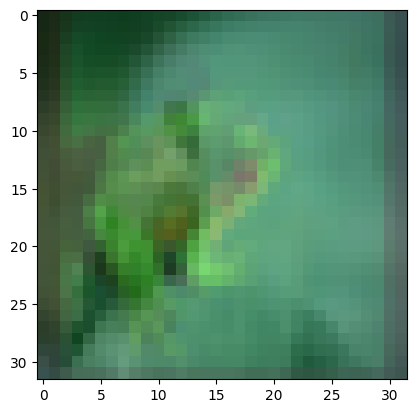

In [7]:
x, y = next(datagen)

print("first: {}, second = {}".format(classes[np.argmax(y[0][0])],classes[np.argmax(y[1][0])+5]))
#print(np.min(x[0]),np.max(x[0]))
plt.imshow(x[0])

# Valutazione

Dfiniamo innanzi tutto il generatore di testing.

In [8]:
testgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,10000)

eval_samples_x, eval_samples_y = next(testgen)
print(eval_samples_x.shape)

(10000, 32, 32, 3)


Testiamo con una nodello che produce predizioni random. Voi dovrete sostituire questo modello con il vostro modello predittivo.

In [9]:
def random_model(x):
  #the random model ingnore the input x and return a pair of random classes
  return(np.random.randint(0,5,(10000,2)))

In [29]:
def eval_model(model):
  eval_samples_x, eval_samples_y = next(testgen)
  random_guesses = model(eval_samples_x)
  correct_guesses_1 = random_guesses[:,0] == np.argmax(eval_samples_y[0],axis=1)
  correct_guesses_2 = random_guesses[:,1] == np.argmax(eval_samples_y[1],axis=1)
  return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2))/2

In [30]:
eval_model(random_model)

0.19924999999999998

let us repeat the evaluation ten times, and comput the standard deviation

In [35]:
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(random_model))
print("mean accuracy = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

mean accuracy =  0.198625
standard deviation =  0.0025019242594451234


# Cosa consegnare

Come di consueto, dovete consegnare un singolo notebook che deve essere eseguibile su colab. Il notebook deve essere adeguatamente commentato a contenere una traccia completa del training, come anche il calcolo della accuratezza secondo le direttive date sopra.

#Buon lavoro!